## Initial Data Observation

- read the raw dataset and discover its shape
- plot some characteristics such as the long tail and metrics

## 0. Import Modules

In [1]:
import os
import sys
from pathlib import Path

# setting proper working directory
PROJECT_DIRECTORY = Path(os.path.abspath('')).resolve().parents[0]
sys.path.extend([str(PROJECT_DIRECTORY)])

print(f'Python {sys.version} on {sys.platform}')
print('Project directory: ', PROJECT_DIRECTORY)

Python 3.12.5 (tags/v3.12.5:ff3bc82, Aug  6 2024, 20:45:27) [MSC v.1940 64 bit (AMD64)] on win32
Project directory:  C:\Users\s8347434\Documents\RecBole-GNN


In [2]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt

In [3]:
def load_data(filename: str, rows: int=None) -> pd.DataFrame:
    """
    Reads the filename as a pandas dataframe.
    
    Attributes:
    ----------
    filename: str
        the filename to read
    rows: int
        the number of entries to read from the file (default is `None` and reads the entire file)

    Returns:
    ----------
    df: pd.DataFRame
        pandas dataframe with the user-item interactions
    """
    with open(filename, 'r', encoding="utf-16") as f:
        objects = csv.reader(f, delimiter="\t")
        
        if rows is None:
            columns_list = list(objects)
        else:
            columns_list = [next(objects) for i in range(rows + 1)]

        df = pd.DataFrame(columns_list[1:], columns=columns_list[0])
        df = df.iloc[:, :3]
        if any(df.columns != ["userID", "itemID", "timestamp"]):
            df.columns = ['userID', 'itemID', 'timestamp']
            
        df['userID'] = df['userID'].astype(np.int64)
        df['itemID'] = df['itemID'].astype(np.int64)
        df["timestamp"] = df["timestamp"].apply(lambda x: pd.to_datetime(str(x).split(".")[0], format="%Y-%m-%d %H:%M:%S"))
        df["timestamp"] = df["timestamp"].apply(lambda x: x.timestamp())

    return df

## 1. Read the raw Dataset

- `ROWS = None` refers to read the entire dataset

In [4]:
FILENAME = PROJECT_DIRECTORY / "asset/data/real-life-raw/user_item_sequence_RAW_ANONYMIZED.txt"
ROWS = None

In [5]:
db_interaction = load_data(FILENAME, rows = ROWS)
print(db_interaction.shape)
print(db_interaction.keys())
print(db_interaction.nunique())

(23545542, 3)
Index(['userID', 'itemID', 'timestamp'], dtype='object')
userID          70309
itemID          37408
timestamp    15093531
dtype: int64


In [9]:
#db_interaction.to_csv("data/real-life-raw/user_item_timestamps_RAW_ANONYMIZED.txt", sep="\t", encoding='utf-16', index=False)

### 1.1 Drop Duplicates

Ignore the downloads of different recordtypes. Drop duplicateted subsets of {`userID`,`itemID`}.

In [10]:
db_interaction_without_duplicates = db_interaction.drop_duplicates(subset=["userID", "itemID"], ignore_index=True)
print(db_interaction_without_duplicates.shape)
print(db_interaction_without_duplicates.nunique())

(17762393, 3)
userID          70309
itemID          37408
timestamp    12705872
dtype: int64


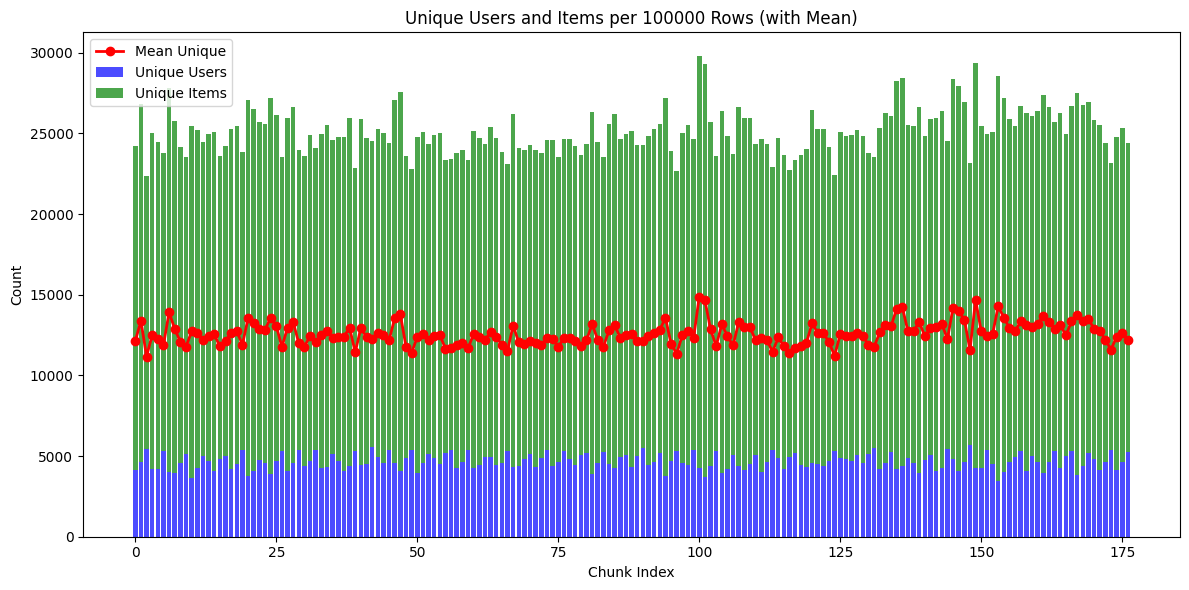

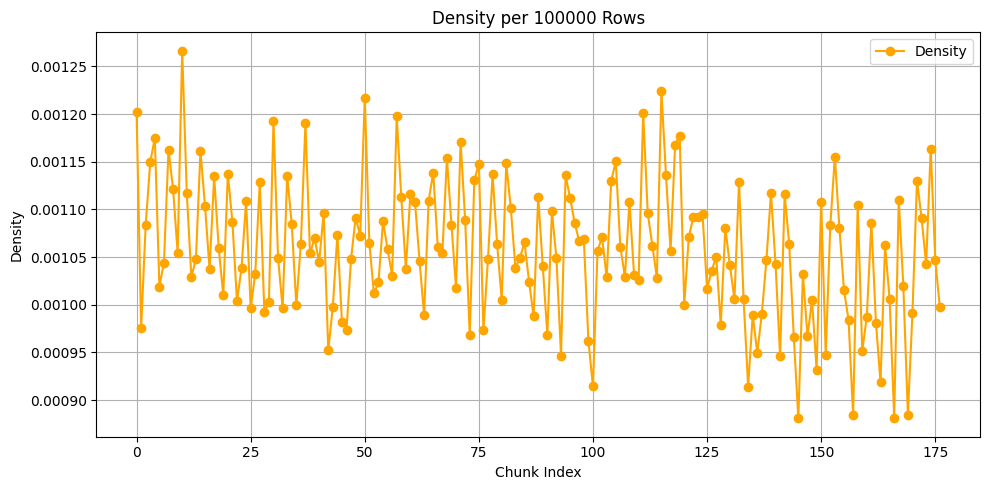

In [11]:
# Chunk size
chunk_size = 100000

# Results placeholders
unique_users = []
unique_items = []
density_per_chunk = []
mean_unique = []

# Iterate over the dataset in chunks
for start_row in range(0, len(db_interaction_without_duplicates), chunk_size):
    # Get the chunk
    chunk = db_interaction_without_duplicates.iloc[start_row:start_row + chunk_size]
    
    # Skip the last chunk if it has fewer rows than the chunk size
    if len(chunk) < chunk_size:
        break
    
    # Count unique users and items
    num_unique_users = chunk['userID'].nunique()
    num_unique_items = chunk['itemID'].nunique()
    unique_users.append(num_unique_users)
    unique_items.append(num_unique_items)
    
    # Calculate density
    num_interactions = len(chunk)
    possible_interactions = num_unique_users * num_unique_items
    density = num_interactions / possible_interactions if possible_interactions > 0 else 0
    density_per_chunk.append(density)
    
    # Calculate the mean of unique users and items
    mean_unique.append((num_unique_users + num_unique_items) / 2)

# Create a DataFrame for plotting
chunks = range(len(unique_users))
data = pd.DataFrame({
    "Unique Users": unique_users,
    "Unique Items": unique_items,
    "Density": density_per_chunk,
    "Mean Unique": mean_unique
}, index=chunks)

# Plot unique users, unique items, and the mean
plt.figure(figsize=(12, 6))
plt.bar(chunks, data["Unique Users"], label="Unique Users", alpha=0.7, color="blue")
plt.bar(chunks, data["Unique Items"], label="Unique Items", alpha=0.7, color="green", bottom=data["Unique Users"])
plt.plot(chunks, data["Mean Unique"], label="Mean Unique", color="red", marker='o', linewidth=2)
plt.title(f"Unique Users and Items per {chunk_size} Rows (with Mean)")
plt.xlabel("Chunk Index")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

# Plot density
plt.figure(figsize=(10, 5))
plt.plot(chunks, data["Density"], marker='o', color='orange', label="Density")
plt.title(f"Density per {chunk_size} Rows")
plt.xlabel("Chunk Index")
plt.ylabel("Density")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
# Directory path
base_dir = './data/real-life-atomic-splits/'

# Create and export each chunk
for i, start_row in enumerate(range(0, len(db_interaction_without_duplicates), chunk_size), start=1):
    # Get the chunk
    chunk = db_interaction_without_duplicates.iloc[start_row:start_row + chunk_size].copy()
    
    # Skip the last chunk if it has fewer rows than the chunk size
    if len(chunk) < chunk_size:
        break
        
    # Reset user and item IDs
    user_mapping = {user_id: new_id for new_id, user_id in enumerate(chunk['userID'].unique())}
    item_mapping = {item_id: new_id for new_id, item_id in enumerate(chunk['itemID'].unique())}
    chunk.loc[:, 'userID_reset'] = chunk['userID'].map(user_mapping)
    chunk.loc[:, 'itemID_reset'] = chunk['itemID'].map(item_mapping)

    
    # Rename columns
    chunk = chunk.rename(columns={
        'userID_reset': 'user_id:token',
        'itemID_reset': 'item_id:token',
        'userID': 'userID:token',
        'itemID': 'itemID:token',
        'timestamp': 'timestamp:float'
    })
    
    # Create directory for this chunk
    split_dir = os.path.join(base_dir, f'real-life-atomic-100000-{i}')
    os.makedirs(split_dir, exist_ok=True)
    
    # File path
    file_path = os.path.join(split_dir, f'real-life-atomic-100000-{i}.inter')
    
    # Save the chunk as a tab-separated file
    chunk.to_csv(file_path, sep='\t', index=False)
    print(f"Saved chunk {i} to {file_path}")

Saved chunk 1 to ./data/real-life-atomic-splits/real-life-atomic-100000-1\real-life-atomic-100000-1.inter
Saved chunk 2 to ./data/real-life-atomic-splits/real-life-atomic-100000-2\real-life-atomic-100000-2.inter
Saved chunk 3 to ./data/real-life-atomic-splits/real-life-atomic-100000-3\real-life-atomic-100000-3.inter
Saved chunk 4 to ./data/real-life-atomic-splits/real-life-atomic-100000-4\real-life-atomic-100000-4.inter
Saved chunk 5 to ./data/real-life-atomic-splits/real-life-atomic-100000-5\real-life-atomic-100000-5.inter
Saved chunk 6 to ./data/real-life-atomic-splits/real-life-atomic-100000-6\real-life-atomic-100000-6.inter
Saved chunk 7 to ./data/real-life-atomic-splits/real-life-atomic-100000-7\real-life-atomic-100000-7.inter
Saved chunk 8 to ./data/real-life-atomic-splits/real-life-atomic-100000-8\real-life-atomic-100000-8.inter
Saved chunk 9 to ./data/real-life-atomic-splits/real-life-atomic-100000-9\real-life-atomic-100000-9.inter
Saved chunk 10 to ./data/real-life-atomic-spli

In [ ]:
# db_interaction_without_duplicates.to_csv("../data/processed/user_item_interaction.txt", sep="\t", encoding='utf-16', index=False)

In [15]:
dataset_number = 2
FILENAME = PROJECT_DIRECTORY / f"asset/data/real-life-atomic-splits/real-life-atomic-100000-{dataset_number}/real-life-atomic-100000-{dataset_number}.inter"
db = pd.read_csv(FILENAME, sep="\t", encoding='utf-8')

In [16]:
first_chunk = db_interaction_without_duplicates.iloc[0:100000]
first_chunk = db

userID = "userID:token"
itemID = "itemID:token"

# Schritt 1: Zähle die Anzahl der Interaktionen pro User
first_chunk['interaction_count'] = first_chunk.groupby(userID)[itemID].transform('count')

# Schritt 2: Filtere User mit weniger als 20 Interaktionen heraus
filtered_df = first_chunk[first_chunk['interaction_count'] >= 20]

# Schritt 3: Berechne die Popularität jedes Items
item_popularity = filtered_df.groupby(itemID)[userID].nunique()

# Schritt 4: Füge die Popularität zu den Interaktionen hinzu
filtered_df['item_popularity'] = filtered_df[itemID].map(item_popularity)

# Schritt 5: Berechne die durchschnittliche Item-Popularität für jeden User
user_avg_popularity = filtered_df.groupby(userID)['item_popularity'].agg(['mean', 'median'])

print(filtered_df['interaction_count'].min())
print(user_avg_popularity)

20
                   mean  median
userID:token                   
1             21.978022     3.0
2             23.413043     5.0
5             41.142857    22.0
6             17.815315     3.0
8              9.139535     5.0
...                 ...     ...
7043           7.175000     3.5
7046          28.692308     9.0
7049          93.080000    84.0
7066          61.541667    43.5
7073          19.507463     4.0

[1089 rows x 2 columns]


C:\Users\s8347434\AppData\Local\Temp\6\ipykernel_27636\1442742865.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['item_popularity'] = filtered_df[itemID].map(item_popularity)


userID                   
1       21.978022     3.0
2       23.413043     5.0
5       41.142857    22.0
6       17.815315     3.0
8        9.139535     5.0
...           ...     ...
7043     7.175000     3.5
7046    28.692308     9.0
7049    93.080000    84.0
7066    61.541667    43.5
7073    19.507463     4.0